# Modeling COVID-19 Spread and Healthcare Capacity # 

Goal is to predict how many COVID-19 patients they will have to provide in-patient medical care for in the next 3 weeks. This will be achieved by modelling the infection rate. Regions that will not have enough resources to cope with their COVID-19 patients in any given week will be matched to a region that will have a surplus of medical resources that week, so that the burden can be shared and more patients can receive life-saving treatment.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from operator import itemgetter
import operator

In [2]:
os.listdir("../data/external")

['time_series_covid19_confirmed_global.csv',
 'country_medical_capacities.csv',
 'prediction_cases.json',
 'time_series_covid19_recovered_global.csv',
 'country_to_code_dict.txt',
 'time_series_covid19_deaths_global.csv']

In [3]:
data_dir = "../data/external/"

In [29]:
# Load datasets

covid_confirmed = pd.read_csv(data_dir+'time_series_covid19_confirmed_global.csv')
covid_deaths = pd.read_csv(data_dir+'time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv(data_dir+'time_series_covid19_recovered_global.csv')

In [30]:
print(f'Last day of Hopkins dataset: {covid_confirmed.columns[-1]}')

Last day of Hopkins dataset: 7/22/20


In [33]:
# Load the start of these datasets
covid_confirmed.head()
#print(covid_deaths.head())
#print(covid_recovered.head())

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  7/13/20  7/14/20  7/15/20  \
0        0        0        0        0  ...    34455    34740    34994   
1        0        0        0        0  ...     3571     3667     3752   
2        0        0        0        0  ...    19689    20216    20770   
3        0        0        0        0  ...      858      861      862   
4        0        0        0        0  ...      525      541      576   

   7/16/20  7/17/20  7/18/20  7/19/20  7/20/20  7/21/20  7/22/20  
0    35070    35229    35301    35475    35526    35615    35727  
1     3851     3906     4008     4090     4171     4290     4358  
2    21355    21948    22549    23084    23691    24278    24872  
3      877      880      880      880      884      884      889  
4      607      638      687      705      749      779      812  

[5 rows x 187 columns]

In [75]:
# Extract all column names
cols_keys = covid_confirmed.keys()
# Make sure all datasets have the same columns
lists = [covid_confirmed.keys(), covid_deaths.keys(), covid_recovered.keys()]
it = iter(lists)
the_len = len(cols_keys)
if not all(len(l) == the_len for l in it):
    raise ValueError('not all lists have same length!')

print(f'Total number of days in database: {len(cols_keys)-4}')

Total number of days in database: 183


In [53]:
# Collect the counts for each date
confirmed = covid_confirmed.loc[:, cols_keys[4]:cols_keys[-1]]
deaths = covid_deaths.loc[:, cols_keys[4]:cols_keys[-1]]
recovered = covid_recovered.loc[:, cols_keys[4]:cols_keys[-1]]
dates = confirmed.keys()

In [74]:
# Calculate totals, rates, and cumulative counts in the world
total_confirmed_global = []
total_deaths_global = []
total_recovered_global = []
mortality_rate_global = []
for d in dates:
    tmp_conf = confirmed[d].sum()
    tmp_deat = deaths[d].sum()
    tmp_reco = recovered[d].sum()
    total_confirmed_global.append(tmp_conf)
    total_deaths_global.append(tmp_deat)
    total_recovered_global.append(tmp_reco)
    mortality_rate_global.append(tmp_deat/tmp_conf)
print(f'Gloabl Coronavirus confirmed cases: {total_confirmed_global[-1]}')
print(f'Gloabl Coronavirus recovered cases: {total_recovered_global[-1]}')
print(f'Gloabl Coronavirus death cases: {total_deaths_global[-1]}')
print(f'Gloabl mortality rate: {total_deaths_global[-1]/total_confirmed_global[-1]:.2%}')

Gloabl Coronavirus confirmed cases: 15227535
Gloabl Coronavirus recovered cases: 8641297
Gloabl Coronavirus death cases: 623385
Gloabl mortality rate: 4.09%


In [59]:
# convert to numpy arrays
days = np.array([i for i in range(len(dates))]).reshape(-1,1)
total_confirmed_global = np.array(total_confirmed_global).reshape(-1,1)
total_deaths_global = np.array(total_deaths_global).reshape(-1,1)
total_recovered_global = np.array(total_recovered_global).reshape(-1,1)

In [63]:
# Exponential growth
def func(x, a, b):
    return a * np.exp(b * x) 

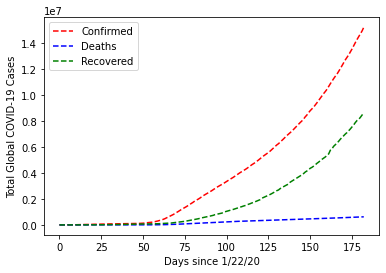

In [76]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
#ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

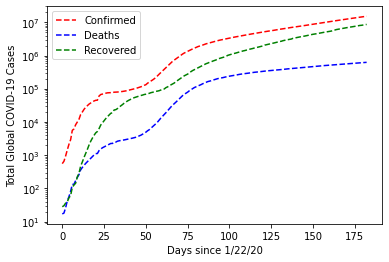

In [77]:
fig, ax = plt.subplots()
ax.plot(days, total_confirmed_global, 'r--', label='Confirmed')
ax.plot(days, total_deaths_global   , 'b--' , label='Deaths')
ax.plot(days, total_recovered_global, 'g--' , label='Recovered')
#ax.plot(days, func(days, *popt), 'b^' , label='Exponential with growth factor = %.2f' % 10**popt[1])
plt.yscale('log')
plt.legend()
plt.xlabel('Days since %s' % dates[0])
plt.ylabel('Total Global COVID-19 Cases')
plt.show()

In [78]:
# Future forcasting for the next 3 weeks
# dates: actual dates
days_in_future = 21
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1,1) # days count including future forecasting
adjusted_dates = future_forecast[:-days_in_future] # days count up to now


In [79]:
# Convert all integers into datetime 
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start,'%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [80]:
# Latest data
latest_confirmed = covid_confirmed[dates[-1]]
latest_deaths = covid_deaths[dates[-1]]
latest_recovered = covid_recovered[dates[-1]]

In [81]:
# List of unique countries
unique_countries = list(covid_recovered['Country/Region'].unique())

In [86]:
# Total number of cases by each country
total_confirmed_by_country = []
total_deaths_by_country = []
total_recovered_by_country = []
mortality_rate_by_country = []
no_cases = []

for i in unique_countries:
    cases_confirmed = latest_confirmed[covid_confirmed['Country/Region']==i].sum()
    cases_deaths = latest_deaths[covid_confirmed['Country/Region']==i].sum()
    cases_recovered = latest_recovered[covid_confirmed['Country/Region']==i].sum()
    #print(i, len(latest_confirmed[covid_confirmed['Country/Region']==i]))
    if cases_confirmed > 0:
        total_confirmed_by_country.append(cases_confirmed)
    else:
        no_cases.append(i)
    if cases_deaths > 0:
        total_deaths_by_country.append(cases_deaths)
    if cases_recovered > 0:
        total_recovered_by_country.append(cases_recovered)

for i in no_cases:
    unique_countries.remove(i)
# Sort based on the number of cases
unique_countries = [k for k,v in sorted(zip(unique_countries, total_confirmed_by_country), key=operator.itemgetter(1), reverse=True) ]
for i in range(len(unique_countries)):
    total_confirmed_by_country[i] = latest_confirmed[covid_confirmed['Country/Region']==unique_countries[i]].sum()

In [87]:
# Print number of cases per country/area
print('Confirmed cases by Countries/Regions')
for i in range(len(unique_countries[:10])):
    print(f'{unique_countries[i]}: {total_confirmed_by_country[i]} cases' )

Confirmed cases by Countries/Regions
US: 3970906 cases
Brazil: 2227514 cases
India: 1238798 cases
Russia: 787890 cases
South Africa: 394948 cases
Peru: 366550 cases
Mexico: 362274 cases
Chile: 334683 cases
United Kingdom: 297952 cases
Iran: 281413 cases


In [88]:
# List of unique province/state
unique_states = list(covid_recovered['Province/State'].unique())

In [91]:
# Total number of cases by each province/state
total_confirmed_by_state = []
no_cases = []
for i in unique_states:
    cases_confirmed = latest_confirmed[covid_confirmed['Province/State']==i].sum()
    if cases_confirmed > 0:
        total_confirmed_by_state.append(cases_confirmed)
    else:
        no_cases.append(i)

for i in no_cases:
    unique_states.remove(i)
    
# Print number of cases per country/area
print('Confirmed cases by Province/State')
for i in range(len(unique_states[:10])):
    print(f'{unique_states[i]}: {total_confirmed_by_state[i]} cases' )

Confirmed cases by Province/State
Australian Capital Territory: 113 cases
New South Wales: 3633 cases
Northern Territory: 31 cases
Queensland: 1074 cases
South Australia: 446 cases
Tasmania: 229 cases
Victoria: 7125 cases
Western Australia: 651 cases
Anhui: 991 cases
Beijing: 929 cases


In [92]:
# handle missing values
nan_indices = []

for i in range(len(unique_states)):
    if type(unique_states[i]) == float:
        nan_indices.append(i)

unique_states = list(unique_states)
total_confirmed_by_state = list(total_confirmed_by_state)

for i in nan_indices:
    unique_states.pop(i)
    total_confirmed_by_state.pop(i)

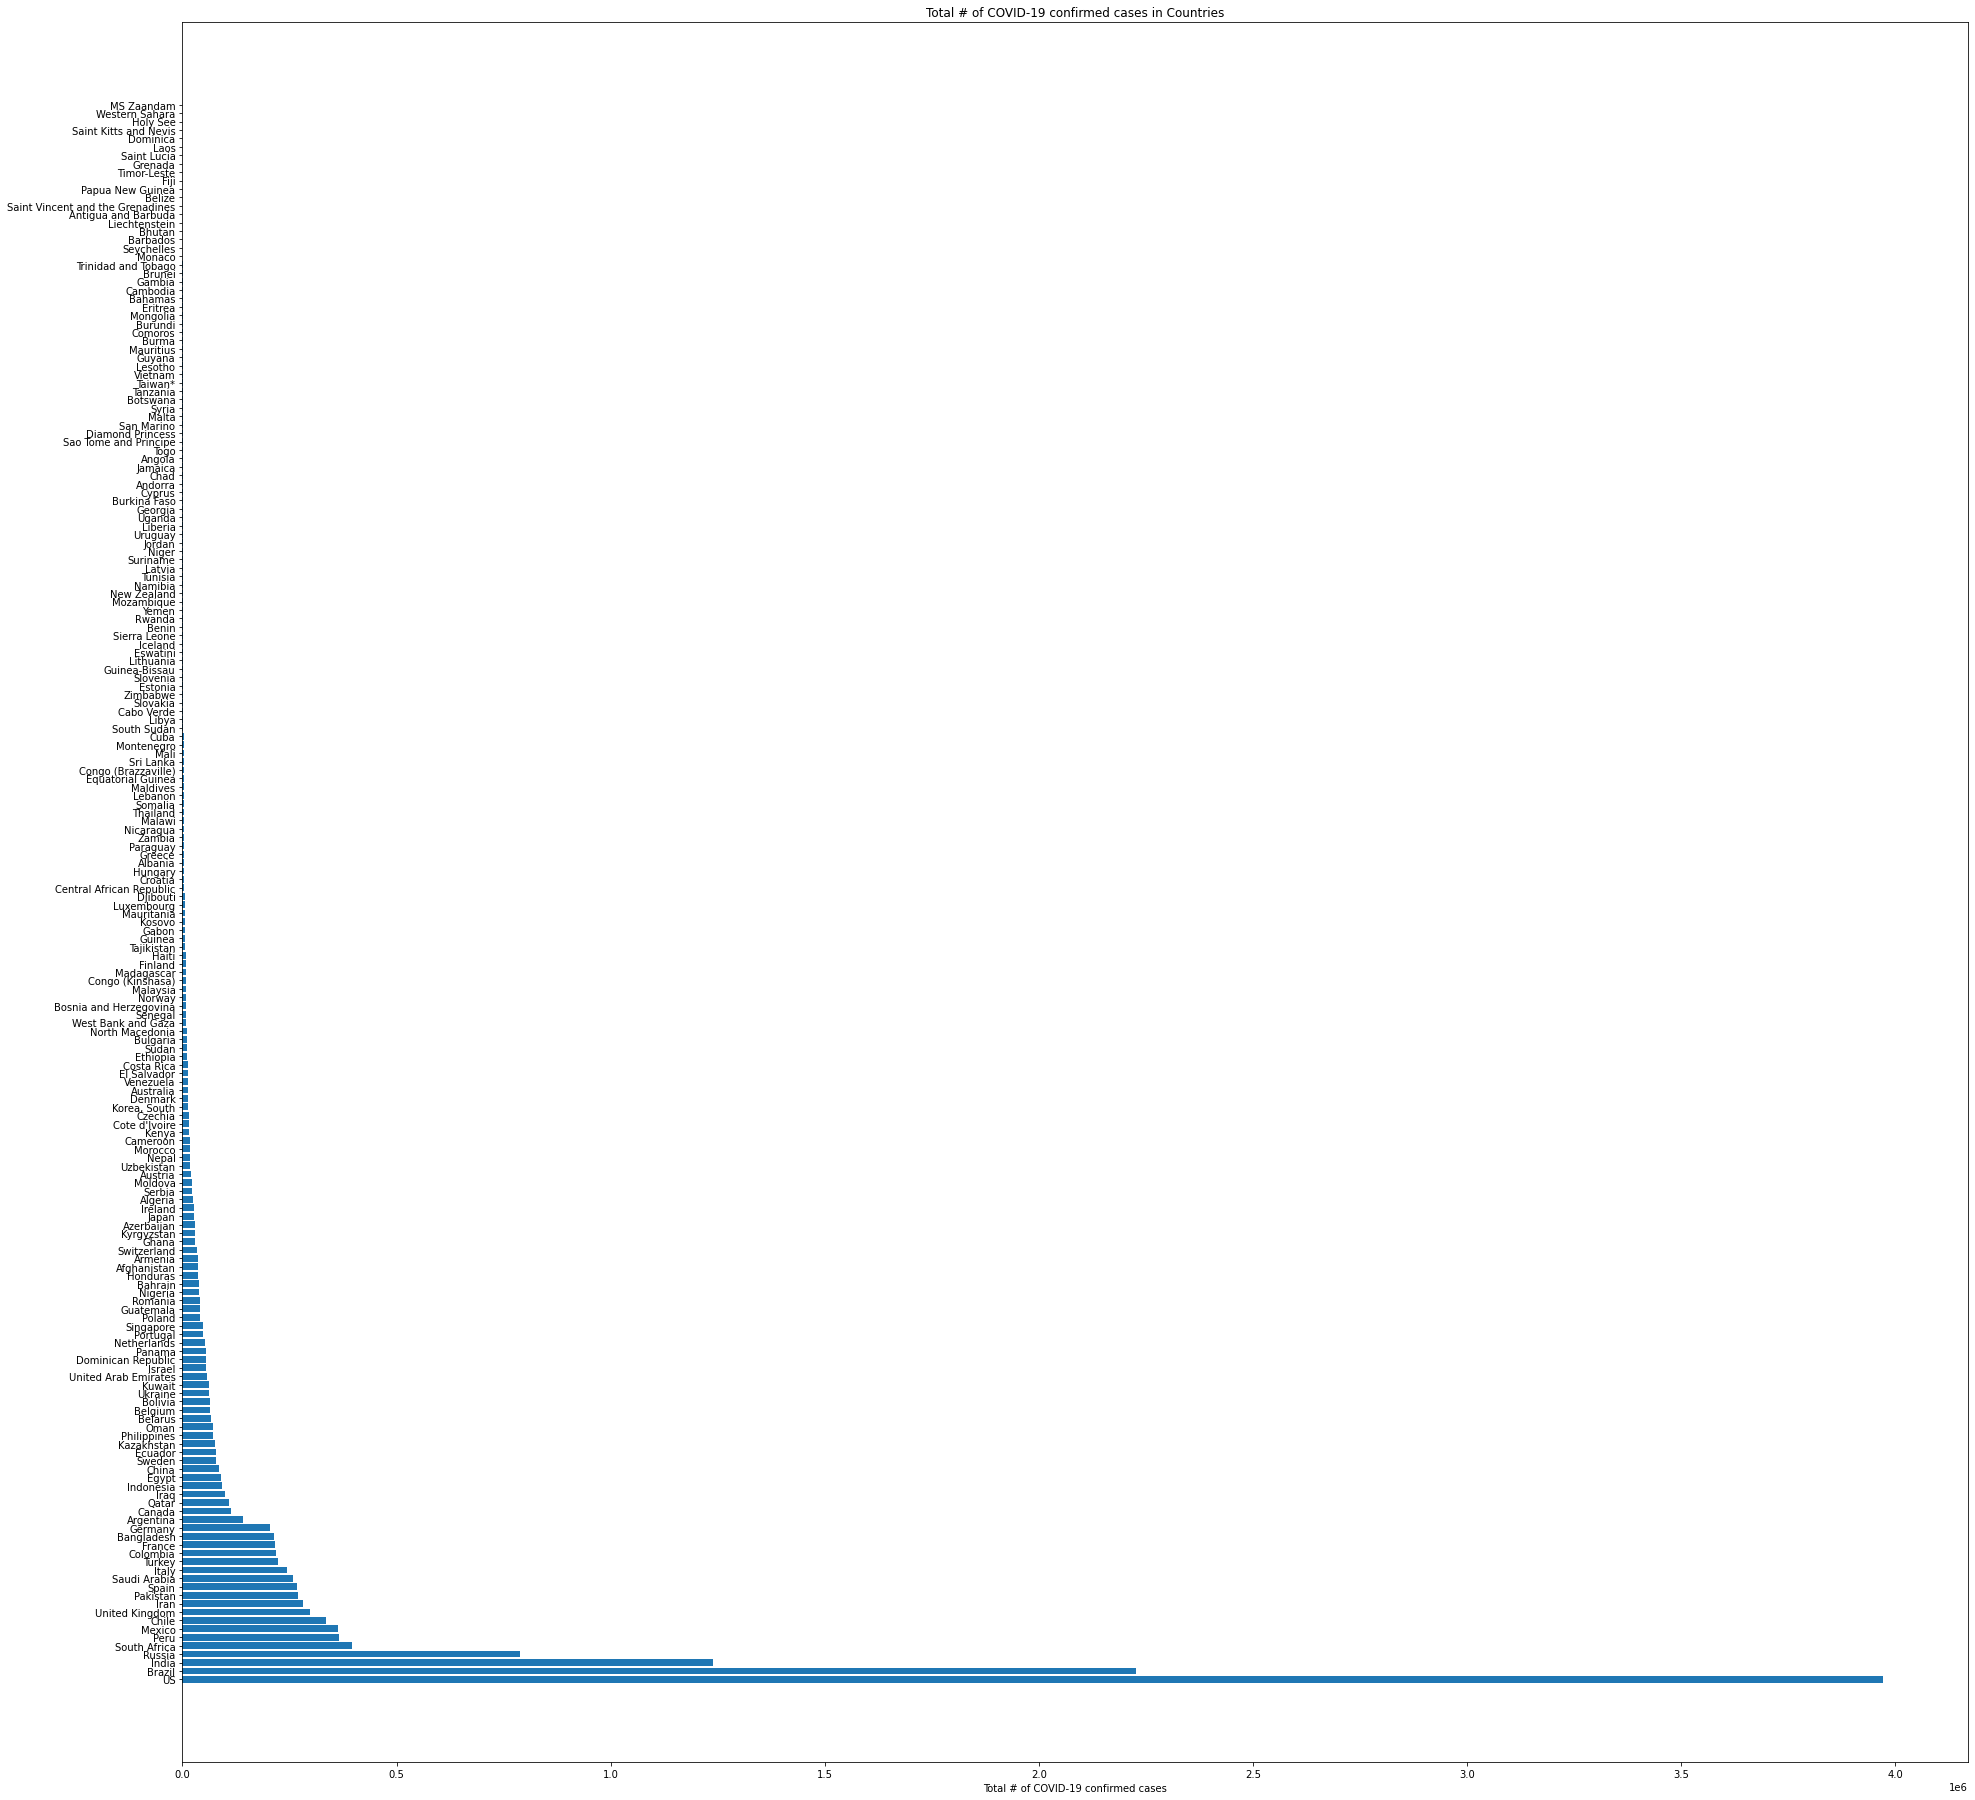

In [93]:
# Some visualization now

plt.figure(figsize=(32,32))
plt.barh(unique_countries, total_confirmed_by_country)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.xlabel("Total # of COVID-19 confirmed cases")
plt.show()

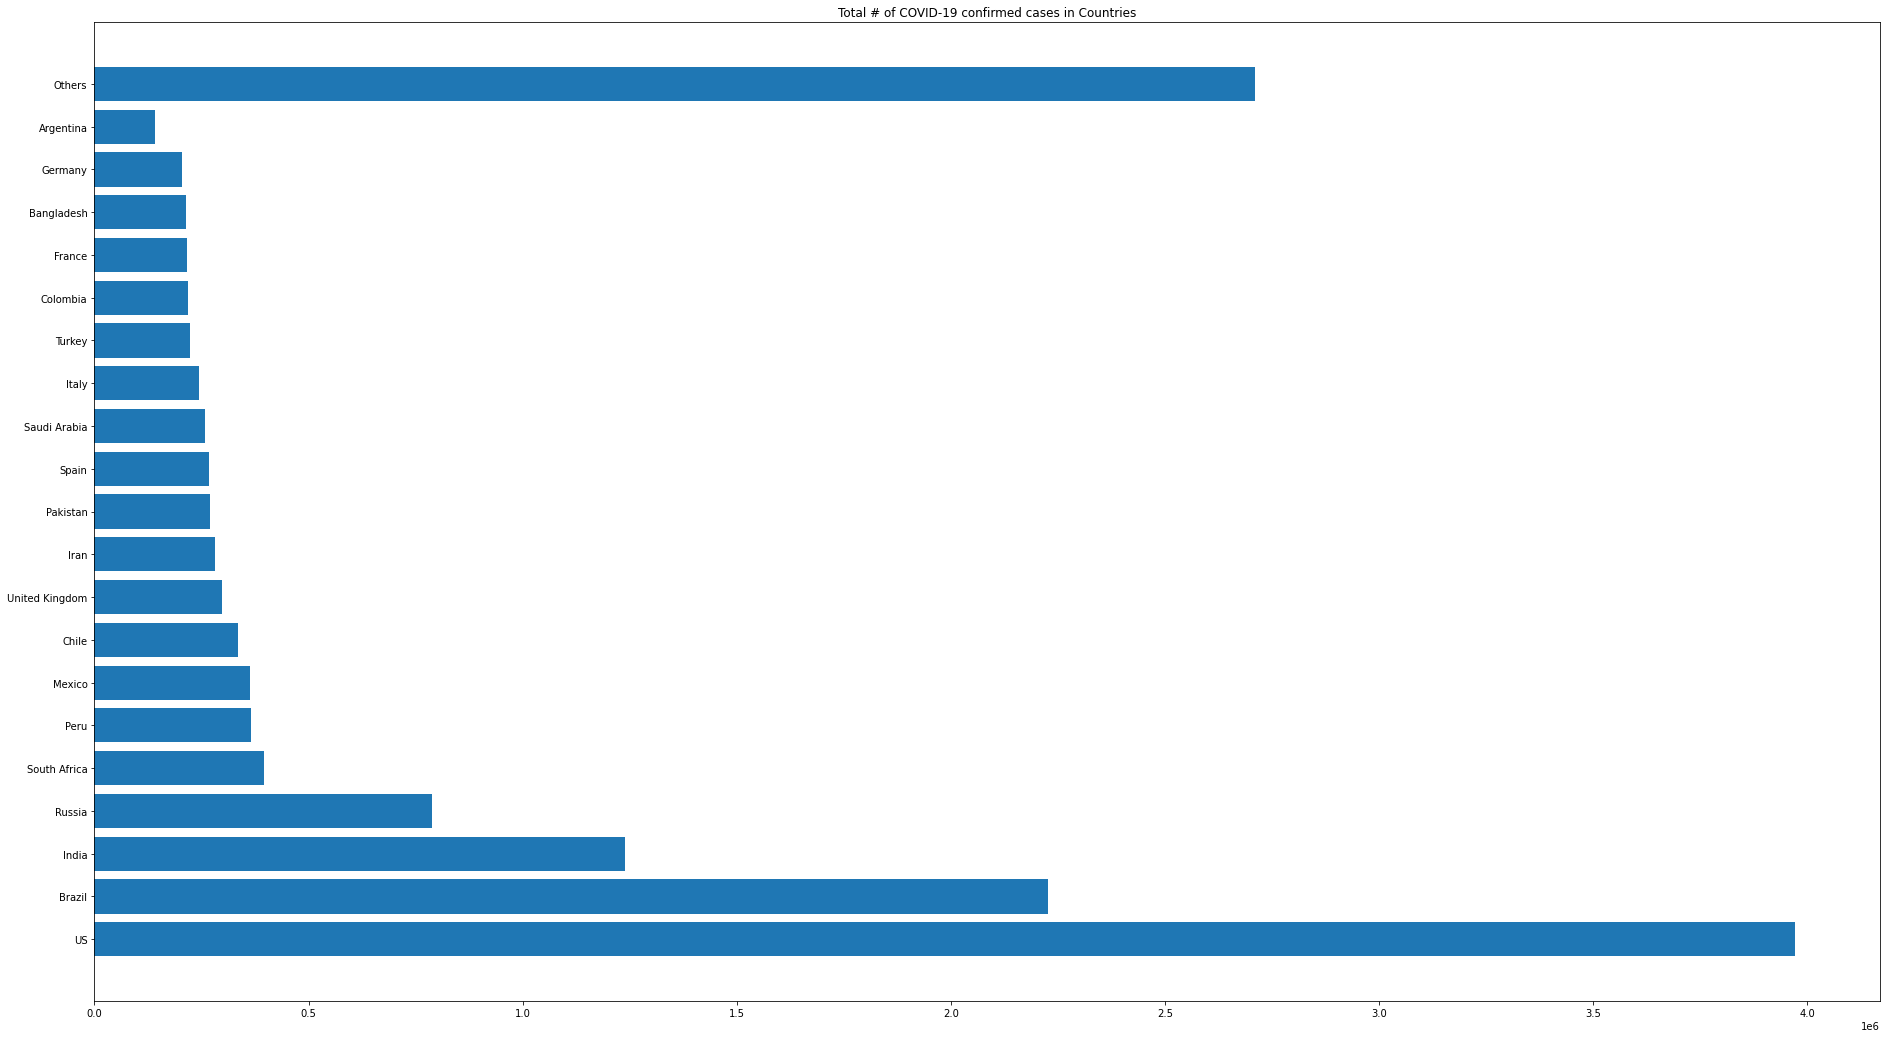

In [94]:
# make it easier to visualize, pick the 10 top cases + other cases
visual_unique_countries = []
visual_confirmed_cases = []
others = np.sum(total_confirmed_by_country[20:])
for i in range(len(total_confirmed_by_country[:20])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(total_confirmed_by_country[i])
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

plt.figure(figsize=(32,18))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title("Total # of COVID-19 confirmed cases in Countries")
plt.show()

## Fit Hopkins data ## 

In [97]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]


** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 17962
	Confirmed cases on 7/15/20 	 16262
	Ratio: 1.1
	Weekly increase: 10.5 %
	Daily increase: 1.4 % per day
	Doubling Time (represents recent growth): 48.8 days

** Based on Logistic Fit**

	R^2: 0.9853325706550444
	Doubling Time (during middle of growth):  135.62 (± 23.46 ) days


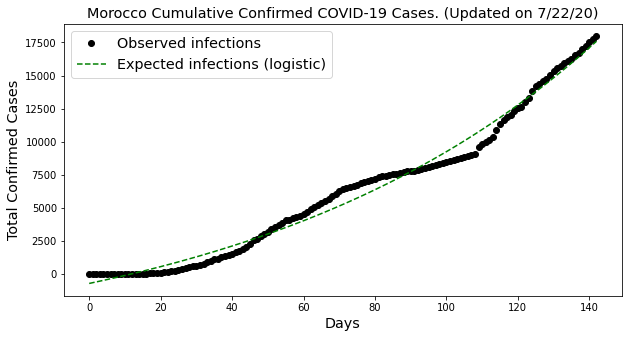

[135.62332392505772,
 23.461458636099273,
 48.8,
 array([ 1.71185509e+07,  1.02216516e-02, -6.28185178e+03,  9.57156432e+10])]

In [113]:
mostrecentdate = dates[-1]
plotCases(covid_confirmed, 'Country/Region', 'Morocco')

In [110]:
covid_confirmed.iloc[1:,[1,-1]]

Country/Region  7/22/20
0              Afghanistan    35727
1                  Albania     4358
2                  Algeria    24872
3                  Andorra      889
4                   Angola      812
..                     ...      ...
261  Sao Tome and Principe      747
262                  Yemen     1640
263                Comoros      337
264             Tajikistan     7015
265                Lesotho      359

[266 rows x 2 columns]

#### Interpreting $R^2$
$R^2$ refers to how close the data are to the fitted regression line
- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.



US

** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 3970906
	Confirmed cases on 7/15/20 	 3498902
	Ratio: 1.13
	Weekly increase: 13.5 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.3 days

** Based on Logistic Fit**

	R^2: 0.9857323488586143
	Doubling Time (during middle of growth):  72.61 (± 14.22 ) days


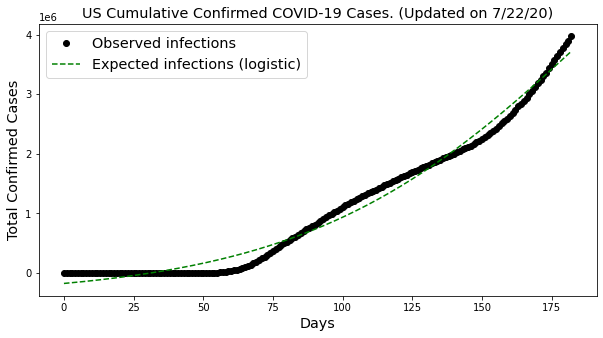



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 2227514
	Confirmed cases on 7/15/20 	 1966748
	Ratio: 1.13
	Weekly increase: 13.3 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 39.0 days

** Based on Logistic Fit**

	R^2: 0.9995083889952904
	Doubling Time (during middle of growth):  27.44 (± 0.55 ) days


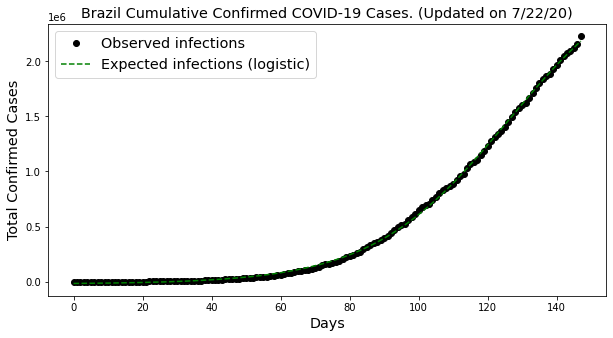



India

** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 1238798
	Confirmed cases on 7/15/20 	 968857
	Ratio: 1.28
	Weekly increase: 27.9 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9994184342365009
	Doubling Time (during middle of growth):  33.73 (± 0.79 ) days


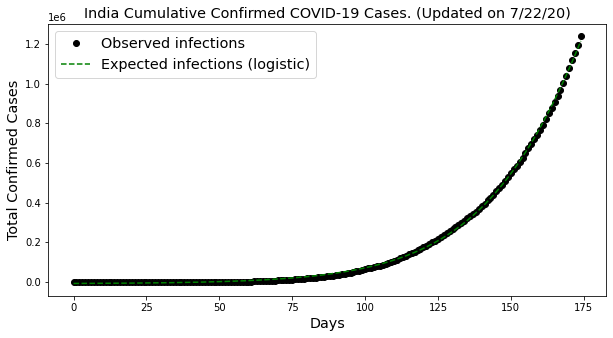



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 787890
	Confirmed cases on 7/15/20 	 745197
	Ratio: 1.06
	Weekly increase: 5.7 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 87.1 days

** Based on Logistic Fit**

	R^2: 0.9965242679513022
	Doubling Time (during middle of growth):  26.14 (± 1.1 ) days


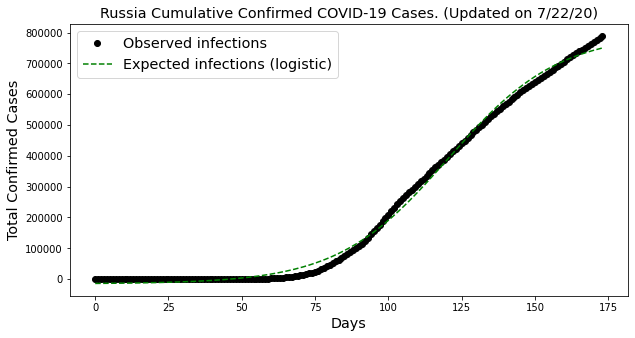



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 394948
	Confirmed cases on 7/15/20 	 311049
	Ratio: 1.27
	Weekly increase: 27.0 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.3 days

** Based on Logistic Fit**

	R^2: 0.9996769544935568
	Doubling Time (during middle of growth):  23.97 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.9727682921101021
	Doubling Time (represents overall growth):  11.4 (± 0.65 ) days


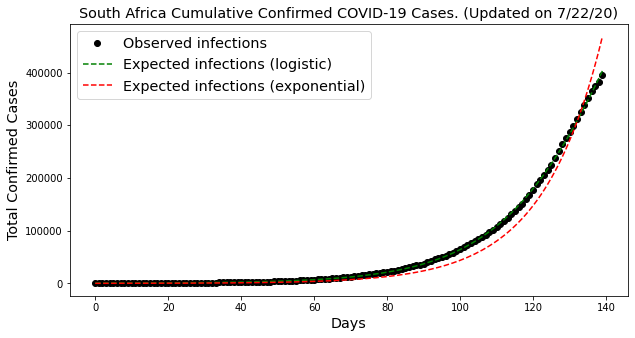

In [114]:
cases = covid_confirmed.iloc[:,[1,-1]].groupby('Country/Region').sum()
cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
params = []
print('\n')
for c in topcountries[:5]:
    print(c)
    a = plotCases(covid_confirmed, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
        params.append(a[3])
    print('\n')

## Prediction for the next 3 weeks ## 

In [134]:
def plotCasesandPredict(dataframe, column, country,days):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Observed infections")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            
            # show curve fit
            plt.plot(x, logistic(x, *lpopt), 'g--', label="Expected infections (logistic)")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
            
            # make predictions
            day_now = y.size-1 # what day we are on now
            future_day = day_now + days # how many days in the future we are predicting
            
            preds_log = [logistic(t,lpopt[0],lpopt[1],lpopt[2],lpopt[3]) for t in list(range(day_now,future_day,1))] # do pred
            x_log = list(range(day_now,future_day,1))
            y_log = preds_log
            plt.ticklabel_format(style = 'plain')
            plt.plot(x_log, y_log, 'y--', label="Predicted infections (logistic)") # plot predictions
            
            print('\n** Predicting day', future_day,'(',days,'days time)**\n')
            print('\tPredicted number of infections (logistic growth):',round(preds_log[-1]))
    
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Expected infections (exponential)")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
            # make predictions
            day_now = y.size-1 # what day we are on now
            future_day = day_now + days # how many days in the future we are predicting
            
            preds_exp = [exponential(t,epopt[0],epopt[1],epopt[2]) for t in list(range(day_now,future_day,1))] # do pred
            x_exp = list(range(day_now,future_day,1))
            y_exp = preds_exp
            plt.ticklabel_format(style = 'plain')
            plt.plot(x_exp, y_exp, 'b--', label="Predicted infections (exponential)") # plot predictions
            
            print('\n** Predicting day', future_day,'(',days,'days time)**\n')
            print('\tPredicted number of infections (exponential growth):',round(preds_exp[-1]))
            
    except:
        pass
        
    plt.title(country + ' Cumulative Confirmed COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Confirmed Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt,round(preds_log[-1])]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime,epopt,round(preds_exp[-1])]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime,lpopt,round(preds_log[-1])]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime,epopt,round(preds_exp[-1])]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime,float('NaN'),float('NaN')]

Do the plots and make the dict

dict in form:
{
  "results":[
    {
      "country_code": "IT",
      "country_name": "Italy",
      "resources_capacity": "39000",
      "confirmed": "40000",
      "deaths": "3000",
      "recovered": "800",
      "confirmed_prediction_3w": "50000",
      "deaths_prediction_3w": "4000",
      "recovered_prediction_3w": "900"
    },
    {
      "country_code": "ES",
      "country_name": "Spain",
      "resources_capacity": "40000",
      "confirmed": "30000",
      "deaths": "2500",
      "recovered": "600",
      "confirmed_prediction_3w": "60000",
      "deaths_prediction_3w": "2800",
      "recovered_prediction_3w": "1200"
      }
   ],
   "timestamp": "2020-03-29 17:05:51.514470"
}



** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 3970906
	Confirmed cases on 7/15/20 	 3498902
	Ratio: 1.13
	Weekly increase: 13.5 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.3 days

** Based on Logistic Fit**

	R^2: 0.9857323488586143
	Doubling Time (during middle of growth):  72.61 (± 14.22 ) days

** Predicting day 203 ( 21 days time)**

	Predicted number of infections (logistic growth): 4588839.0


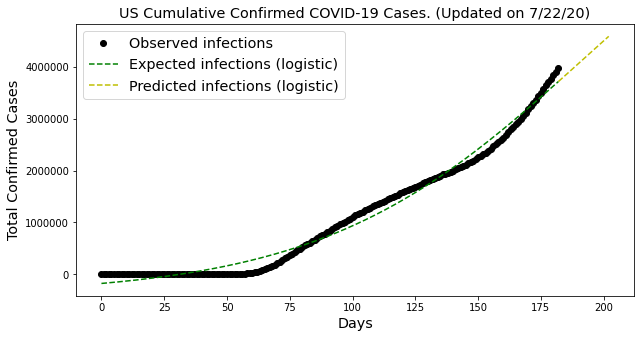


** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 2227514
	Confirmed cases on 7/15/20 	 1966748
	Ratio: 1.13
	Weekly increase: 13.3 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 39.0 days

** Based on Logistic Fit**

	R^2: 0.9995083889952904
	Doubling Time (during middle of growth):  27.44 (± 0.55 ) days

** Predicting day 168 ( 21 days time)**

	Predicted number of infections (logistic growth): 2613876.0


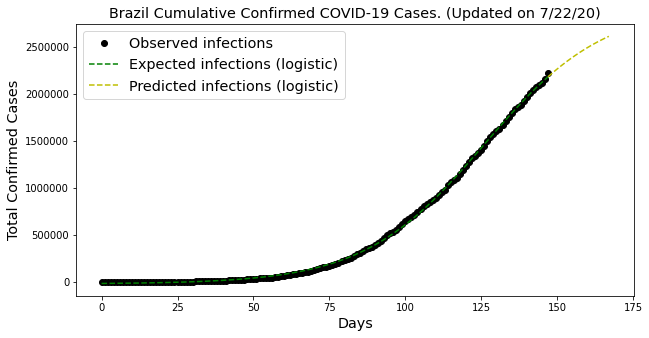


** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 1238798
	Confirmed cases on 7/15/20 	 968857
	Ratio: 1.28
	Weekly increase: 27.9 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9994184342365009
	Doubling Time (during middle of growth):  33.73 (± 0.79 ) days

** Predicting day 195 ( 21 days time)**

	Predicted number of infections (logistic growth): 2036832.0


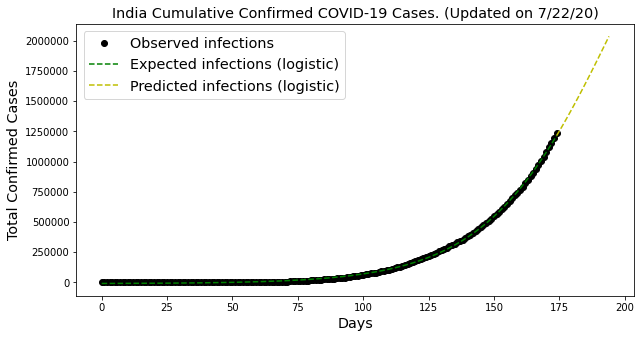


** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 787890
	Confirmed cases on 7/15/20 	 745197
	Ratio: 1.06
	Weekly increase: 5.7 %
	Daily increase: 0.8 % per day
	Doubling Time (represents recent growth): 87.1 days

** Based on Logistic Fit**

	R^2: 0.9965242679513022
	Doubling Time (during middle of growth):  26.14 (± 1.1 ) days

** Predicting day 194 ( 21 days time)**

	Predicted number of infections (logistic growth): 780219.0


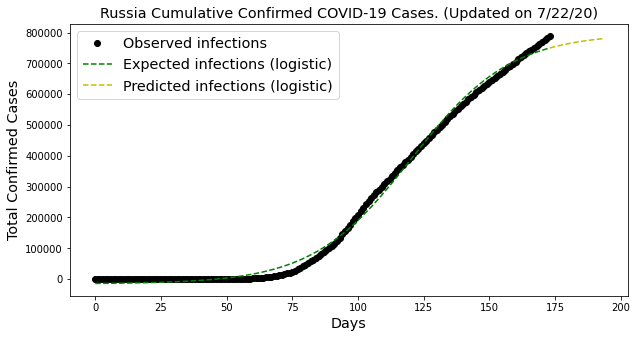


** Based on Most Recent Week of Data **

	Confirmed cases on 7/22/20 	 394948
	Confirmed cases on 7/15/20 	 311049
	Ratio: 1.27
	Weekly increase: 27.0 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.3 days

** Based on Logistic Fit**

	R^2: 0.9996769544935568
	Doubling Time (during middle of growth):  23.97 (± 0.44 ) days

** Predicting day 160 ( 21 days time)**

	Predicted number of infections (logistic growth): 703131.0

** Based on Exponential Fit **

	R^2: 0.9727682921101021
	Doubling Time (represents overall growth):  11.4 (± 0.65 ) days

** Predicting day 160 ( 21 days time)**

	Predicted number of infections (exponential growth): 1580825.0


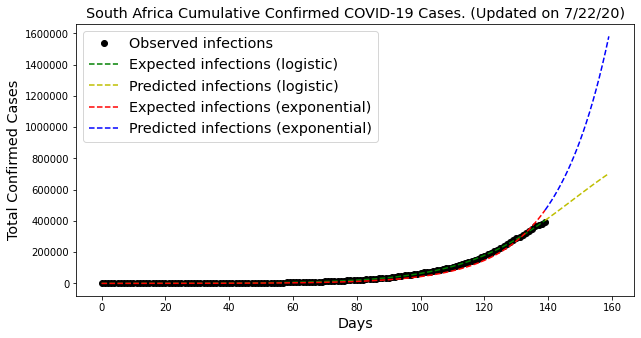

In [136]:
countries = ['Italy','US','Switzerland','Iran','United Kingdom','Germany','Spain']
dataframe = covid_confirmed
column = "Country/Region"
days = 21
from datetime import datetime
timestamp = datetime.now()

results = {"results":[],"timestamp":timestamp}
results_keys = ['country_code','country_name','resources_capacity','confirmed','deaths','recovered','confirmed_prediction_3w','deaths_prediction_3w','recovered_prediction_3w']

for c in topcountries[:5]:
#for c in countries:
    # run
    dbltime,dbltimeerr,recentdbltime,params,pred = plotCasesandPredict(dataframe,column,c,days)
    
    # initialise dict of results
    results_dict = dict.fromkeys(results_keys)
    
    # generate dict values
    country_code = "TEST" # add later
    country_name = c
    resources_capacity = "TEST" #???
    confirmed = int(dataframe[dataframe['Country/Region']==c].iloc[:,-1].sum())
    deaths = int(covid_deaths[covid_deaths['Country/Region']==c].iloc[:,-1].sum())
    recovered = int(covid_recovered[covid_recovered['Country/Region']==c].iloc[:,-1].sum())
    confirmed_prediction_3w = int(pred) # we take the prediction
    deaths_prediction_3w = int(deaths/confirmed * confirmed_prediction_3w) # use current perc deaths
    recovered_prediction_3w = int(recovered/confirmed * confirmed_prediction_3w) # use current perc recovered
    
    # populate dict
    results_dict['country_code'] = country_code
    results_dict['country_name'] = country_name
    results_dict['resources_capacity'] = resources_capacity
    results_dict['confirmed'] = confirmed
    results_dict['deaths'] = deaths
    results_dict['recovered'] = recovered
    results_dict['confirmed_prediction_3w'] = confirmed_prediction_3w
    results_dict['deaths_prediction_3w'] = deaths_prediction_3w
    results_dict['recovered_prediction_3w'] = recovered_prediction_3w
    
    # append to master dict
    results['results'].append(results_dict)
    
    
    
    

In [137]:
results

{'results': [{'country_code': 'TEST',
   'country_name': 'US',
   'resources_capacity': 'TEST',
   'confirmed': 3970906,
   'deaths': 143190,
   'recovered': 1210849,
   'confirmed_prediction_3w': 4588839,
   'deaths_prediction_3w': 165472,
   'recovered_prediction_3w': 1399275},
  {'country_code': 'TEST',
   'country_name': 'Brazil',
   'resources_capacity': 'TEST',
   'confirmed': 2227514,
   'deaths': 82771,
   'recovered': 1591975,
   'confirmed_prediction_3w': 2613876,
   'deaths_prediction_3w': 97127,
   'recovered_prediction_3w': 1868102},
  {'country_code': 'TEST',
   'country_name': 'India',
   'resources_capacity': 'TEST',
   'confirmed': 1238798,
   'deaths': 29861,
   'recovered': 782607,
   'confirmed_prediction_3w': 2036832,
   'deaths_prediction_3w': 49097,
   'recovered_prediction_3w': 1286762},
  {'country_code': 'TEST',
   'country_name': 'Russia',
   'resources_capacity': 'TEST',
   'confirmed': 787890,
   'deaths': 12726,
   'recovered': 571049,
   'confirmed_predic